In [42]:
import numpy as np
import torch
import torch as tr
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")
data

NpzFile 'tiny_nerf_data.npz' with keys: images, poses, focal

In [3]:
def resize_to(images, height, width):
    # images: (B, old_H, old_W, C)

    # (B, C, old_H, old_W)
    images = images.permute(0, 3, 1, 2)

    transform = tv.transforms.Compose([
        tv.transforms.Resize((height, width))
    ])

    # (B, C, new_H, new_W)
    resized_images = torch.stack([
        # (C, new_H, new_W)
        transform(image)
        for image in images
    ])

    # (B, new_H, new_W, C)
    resized_images = resized_images.permute(0, 2, 3, 1)

    return resized_images


In [4]:
images = data['images']
poses = data['poses']
focal_length = data['focal']

# Images
# (B, H, W, C)
images = torch.from_numpy(images)
images = resize_to(images, 32, 32)
# Camera extrinsics (poses)
poses = torch.from_numpy(poses)
# Focal length (intrinsics)
focal_length = torch.from_numpy(focal_length)
# Rescale focal length
focal_length = focal_length * 32.0 / 100.0

print(images.shape)
print(poses.shape)
print(focal_length)

height, width = images.shape[1:3]

torch.Size([106, 32, 32, 3])
torch.Size([106, 4, 4])
tensor(44.4444, dtype=torch.float64)


In [5]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.
  
  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  
  ii, jj = torch.meshgrid(
      torch.arange(width),
      torch.arange(height),
      indexing='xy'
  )

  # (H, W, 3)
  directions = torch.stack(
    [
      (ii - width * .5) / focal_length,
      -(jj - height * .5) / focal_length,
      -torch.ones_like(ii)
    ],
    dim=-1
  )

  # ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)

  ray_directions = directions @ tform_cam2world[:3, :3].T
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions


In [6]:
def nf_get_ray_bundle(
    height: int,
    width: int,
    focal_length: torch.Tensor,
    pose: torch.Tensor
):
    points_x, points_y = torch.meshgrid(
        torch.arange(width),
        torch.arange(height),
        indexing='xy'
    )

    points_x = (points_x - width / 2.0) / focal_length
    # Note the -ve here, y in grid increases downwards while
    # y in NDC increases upwards
    points_y = -(points_y - height / 2.0) / focal_length
    points_z = -tr.ones_like(points_x)

    ray_dirs = tr.stack(
        (
            points_x,
            points_y,
            points_z,
        ),
        dim=-1
    )

    transform_rot = pose[:3, :3]
    ray_dirs = ray_dirs @ transform_rot.T

    ray_origins = pose[:3, -1].expand(ray_dirs.shape)

    return ray_origins, ray_dirs


In [7]:
ao, ad = nf_get_ray_bundle(height, width, focal_length, poses[0])
bo, bd = get_ray_bundle(height, width, focal_length, poses[0])

tr.all(ao == bo), tr.all(ad == bd)

(tensor(True), tensor(True))

In [9]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize = False
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".
  
  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values


In [10]:
def nf_create_query_points(
    # (H, W, 3)
    ray_origins: torch.Tensor,
    # (H, W, 3)
    ray_dirs: torch.Tensor,
    thresh_near: float,
    thresh_far: float,
    num_samples_per_ray: int,
):
    # TODO: randomize

    # (N,)
    depths = torch.linspace(thresh_near, thresh_far, num_samples_per_ray)

    # (H, W, N, 3)
    query_points = (
        ray_origins[..., None, :]
        + ray_dirs[..., None, :] * depths[:, None]
    )

    return query_points, depths


In [11]:
aq, az = nf_create_query_points(ao, ad, 2, 6, 32)
bq, bz = compute_query_points_from_rays(bo, bd, 2, 6, 32)

tr.all(aq == bq), tr.all(az == bz)

(tensor(True), tensor(True))

In [12]:
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    cumprod = torch.cumprod(tensor, dim=-1)
    cumprod = torch.roll(cumprod, 1, dims=-1)
    cumprod[..., 0] = 1.
    return cumprod

In [13]:
def render_volume_density(
    radiance_field: torch.Tensor,
    depth_values: torch.Tensor
):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  
  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """

  # TESTED

  # radiance_field : (H, W, N, 4)
  # depth_values : (H, W, N)

  # (H, W, N, 3)
  rgb = torch.sigmoid(radiance_field[..., :3])

  # (H, W, N)
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])

  # (1,)
  one_e_10 = torch.tensor([1e10])

  # (H, W, N)
  dists = torch.cat(
    (
      # (H, W, N - 1)
      depth_values[..., 1:] - depth_values[..., :-1],
      # (H, W, 1)
      one_e_10.expand(depth_values[..., :1].shape)
    ),
    dim=-1
  )

  # (H, W, N)
  alpha = 1. - torch.exp(-sigma_a * dists)
  # (H, W, N)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  # (H, W, N, 3)
  rgb_map_points = (
    # (H, W, N, 1)
    weights[..., None]
    *
    # (H, W, N, 3)
    rgb
  )

  # (H, W, 3)
  rgb_map = rgb_map_points.sum(dim=-2)

  # depth_map = (weights * depth_values).sum(dim=-1)
  # acc_map = weights.sum(-1)

  return rgb_map

In [14]:
def nf_render_view(
    # (H, W, N, 4)
    view_field: torch.Tensor,
    # (N,) or (H, W, N)
    depths: torch.Tensor,
):
    # (H, W, N, 3)
    rgb_field = view_field[..., :3]
    # (H, W, N)
    sigma_field = view_field[..., 3]

    rgb_field = F.sigmoid(rgb_field)
    sigma_field = F.relu(sigma_field)

    # (*, N - 1)
    deltas = depths[..., 1:] - depths[..., :-1]

    # (*, N)
    deltas = torch.cat(
        (
            # (*, N - 1)
            deltas,
            # (*, 1)
            torch.tensor([1e10]).expand(deltas[..., :1].shape)
        ),
        dim=-1
    )

    # (H, W, N)
    alpha = 1. - torch.exp(-sigma_field * deltas)
    # (H, W, N)
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

    # (H, W, N, 3)
    rgb_map_points = (
      # (H, W, N, 1)
      weights[..., None]
      *
      # (H, W, N, 3)
      rgb_field
    )

    # (H, W, 3)
    rgb_map = rgb_map_points.sum(dim=-2)

    return rgb_map



In [15]:
rad_field = tr.randn(height, width, 32, 4)

argb = nf_render_view(rad_field, az)
brgb = render_volume_density(rad_field, az)

torch.all(argb == brgb)

tensor(True)

In [16]:
def positional_encoding(
    # (*, D (3))
    points,
    L=6,
):
    encoding = [points]

    freqs = 2.0 ** torch.linspace(0.0, L - 1, L)

    for freq in freqs:
        encoding.append(torch.sin(points * freq))
        encoding.append(torch.cos(points * freq))

    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)


def split_points_into_chunks(
    # (B, L)
    points: torch.Tensor,
    chunk_size: int
):
    return [
        points[i:i + chunk_size]
        for i in range(0, points.shape[0], chunk_size)
    ]

In [23]:
def nf_render_pose(
    model: torch.nn.Module,
    height: int,
    width: int,
    focal_length: int,
    pose: torch.Tensor,
    thresh_near: int,
    thresh_far: int,
    num_samples_per_ray: int,
    chunk_size: int,
):

    # Create rays
    ray_origins, ray_dirs = nf_get_ray_bundle(
        height,
        width,
        focal_length,
        pose
    )

    # Create query points
    query_points, depths = nf_create_query_points(
        ray_origins,
        ray_dirs,
        thresh_near,
        thresh_far,
        num_samples_per_ray,
    )

    # pass query points to model
    """
    model: (B, 3) -> (B, 4)
    """

    # (H, W, N, 3)
    # query_points

    # (H*W*N, 3)
    flat_query_points = query_points.view(-1, 3)

    # apply positional encoding
    flat_query_points = positional_encoding(flat_query_points)

    # convert flat_query_points to chunks
    chunks = split_points_into_chunks(
        flat_query_points, chunk_size)
    outputs = []

    for chunk in chunks:
        # (Bi, 4)
        chunk_view_field = model(chunk)
        outputs.append(chunk_view_field)

    # (H*W*N, 4)
    flat_view_field = torch.cat(outputs, dim=0)

    # create view (radiance field)
    # (H, W, N, 4)
    view_field = flat_view_field.view(
        list(query_points.shape[:-1]) + [-1]
    )

    rgb_map = nf_render_view(
        view_field,
        depths   
    )

    return rgb_map

In [27]:
class VeryTinyNerfModel(torch.nn.Module):
    def __init__(
        self,
        filter_size=128,
        num_encoding_functions=6
    ):

        super(VeryTinyNerfModel, self).__init__()
        # Input layer (default: 39 -> 128)
        self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [28]:
model = VeryTinyNerfModel()

In [83]:
def predict(pose: torch.Tensor):
    return nf_render_pose(
        model,
        height,
        width,
        focal_length,
        pose=pose,
        thresh_near=2,
        thresh_far=6,
        num_samples_per_ray=32,
        chunk_size=8096,
    )

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [84]:
# Train
for i in range(100):
    idx = torch.randint(images.shape[0], (1,)).item()
    target_pose = poses[idx]
    # (H, W, 3)
    target_image = images[idx]
    
    # (H, W, 3)
    image_predicted = predict(target_pose)

    loss = F.mse_loss(image_predicted, target_image)

    if i % 10 == 0:
        print(f"{i}: {loss.item()}") 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0: 0.006026849616318941
10: 0.0058042374439537525
20: 0.003926482051610947
30: 0.0037257529329508543
40: 0.008596851490437984
50: 0.005437550600618124
60: 0.008384843356907368
70: 0.0043747504241764545
80: 0.004508476238697767
90: 0.006997155491262674


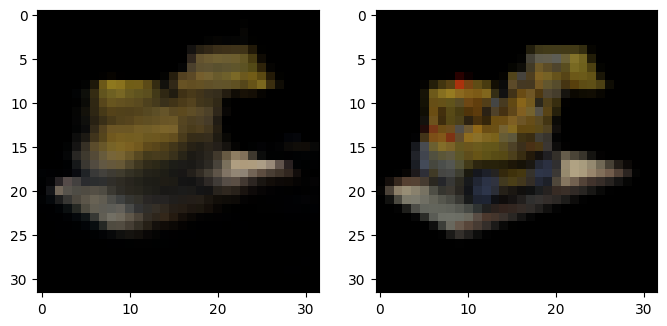

In [90]:
test_idx = torch.randint(images.shape[0], (1,)).item()

plt.figure(figsize=(8,4))

predicted = predict(poses[test_idx]).detach()
plt.subplot(1,2,1)
plt.imshow(predicted)

plt.subplot(1,2,2)
plt.imshow(images[test_idx])